In [1]:
from __future__ import print_function, division

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#pd.set_option('display.max_rows', 500)


%matplotlib inline

In [3]:
import datetime

In [219]:
df =  pd.DataFrame(dict(A=list('XXXXYYYYYY'),B=range(10)))

s = df.groupby('A') #.B.pipe(lambda g: df.B / g.transform('sum') / g.ngroups)

df

,A,B
0,X,0
1,X,1
2,X,2
3,X,3
4,Y,4
5,Y,5
6,Y,6
7,Y,7
8,Y,8
9,Y,9


In [223]:
df.groupby('A').transform('sum')

,B
0,6
1,6
2,6
3,6
4,39
5,39
6,39
7,39
8,39
9,39


In [4]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
#DATA for Jan - March 2020 &  March 2019
weeks_march_2019 = [190302, 190309, 190316, 190323, 190330]
week_nums_march_2020 = [200328,200321,200314,200307]
week_nums_jan_feb_2020 =  [200104, 200111, 200118, 200125,  200201, 200208, 200215, 200222, 200229 ]
week_nums = weeks_march_2019 + week_nums_march_2020  + week_nums_jan_feb_2020
turnstiles_df = get_data(week_nums)
df = turnstiles_df
df = turnstiles_df[~turnstiles_df['DATE'].isin([ '02/28/2019',  '04/01/2019', '04/02/2019', '04/03/2019', '04/04/2019', '04/05/2019', '04/06/2019', '12/31/2019','12/30/2019', '12/29/2019', '12/28/2019', '02/23/2019', '02/24/2019', '02/25/2019', '02/26/2019', '02/27/2019', '02/28/2019', '04/01/2019','04/02/2019','04/03/2019', '04/04/2019', '04/05/2019'])] 
df.DATE.value_counts().sort_index()

turnstiles_df = df
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [5]:
#turnstiles_df.to_pickle('/tmp/mta_pickle_all')

In [59]:
from datetime import datetime as dt

In [60]:
#turnstiles_df = pd.read_pickle('/tmp/mta_pickle_all')

In [61]:
turnstiles_df['DATE'] = pd.to_datetime(turnstiles_df['DATE'])



In [62]:
turnstiles_df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                    datetime64[ns]
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
DATE_TIME                                  

In [63]:
index_names = turnstiles_df[ turnstiles_df['DESC'] == 'RECOVR AUD' ].index
turnstiles_df.drop(index_names , inplace=True)


In [64]:
df_ts_grouped_by_datetime = (turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME', "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))

In [65]:
#df_ts_grouped_by_datetime[ df_ts_grouped_by_datetime.ENTRIES > 1  ]  #No entries greater than 1

In [66]:
turnstiles_df = turnstiles_df.drop(["EXITS"], axis=1, errors="ignore")

In [67]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION",'LINENAME', "DATE"],as_index=False)
                        .ENTRIES.first())

In [68]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,2019-03-01,6962243
1,A002,R051,02-00-00,59 ST,NQR456W,2019-03-02,6964163
2,A002,R051,02-00-00,59 ST,NQR456W,2019-03-03,6964363
3,A002,R051,02-00-00,59 ST,NQR456W,2019-03-04,6964904
4,A002,R051,02-00-00,59 ST,NQR456W,2019-03-05,6966309


In [69]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME'])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [70]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [71]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1070,A002,R051,02-05-00,59 ST,NQR456W,2020-01-01,49,2019-03-29,111.0
1302,A002,R051,02-06-00,59 ST,NQR456W,2020-01-01,30312,2019-03-29,135964.0
1346,A002,R051,02-06-00,59 ST,NQR456W,2020-02-14,922,2020-02-13,82692.0
2067,A006,R079,00-03-00,5 AV/59 ST,NQRW,2020-03-11,76,2020-03-10,9437450.0
2444,A007,R079,01-05-01,5 AV/59 ST,NQRW,2020-01-01,0,2019-03-28,1.0


In [72]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=200000)

7328037 6997512.0
6511722 6237606.0
1372754 1048053.0
6457283 6131481.0
5979201 5692813.0
7380772 7067135.0
11811311 11341610.0
9243534 8905175.0
524289 153.0
4184511 3794537.0
5333774 4960659.0
6388853 6097728.0
3170065 2923143.0
7840653 7605986.0
9375307 9060182.0
76 9437450.0
504374 100437.0
836320 290527.0
119577349 119275739.0
5063441 4809808.0
7743931 7319006.0
4805060 4214814.0
15484087 15051105.0
11311787 10970383.0
3738638 3428739.0
4652697 4260240.0
2026147 1446041.0
19488726 18652234.0
3129623 1701085.0
402929 108184.0
582523 147172.0
601568 158264.0
906409 233888.0
3915671 2865992.0
5121856 4781975.0
6384227 6064221.0
6094500 5779907.0
257350 19670.0
347657 28181.0
432430 35375.0
12917816 12415845.0
1012696 561854.0
4197632 3783934.0
9031702 8679150.0
7436986 7119855.0
108617 6017107.0
3986329 3684887.0
5855738 5467867.0
15185657 14647018.0
9472897 8689737.0
3886290 3291926.0
2734282 2300347.0
2725964 2352250.0
2440501 2131549.0
1856049 1630341.0
2115851 1836027.0
3430975 2

7944925 7550989.0
771686 8848471.0
5155074 4710572.0
6326433 6039773.0
1658436 1171555.0
1926934882 1927300892.0
2311424 1571998.0
3051604 2847186.0
7477462 6986642.0
4860766 4132867.0
923011 239378.0
209 1100925.0
9169914 8550086.0
4668417 4281613.0
10845197 10552660.0
7759376 7551948.0
2923375 2588000.0
1664395965 1663972569.0
7928659 7713166.0
5697507 5425433.0
7331517 7061997.0
9060691 8723387.0
1694314 1201570.0
4735028 4459486.0
7090849 6803459.0
8042056 7587422.0
4174008 3922454.0
2111568 1573374.0
1859053 1604205.0
42123 2663578.0
43804 4206034.0
6649409 6342332.0
3754183 3295473.0
8703581 8394059.0
104405 5329652.0
9529320 9245840.0
8493985 8244029.0
3952925 3648694.0
430168 15329324.0
15148245 14586871.0
4606211 4291262.0
33611839 186793.0
33825938 33612905.0
8517402 8025370.0
9493387 9080266.0
10234553 9784755.0
254350 29.0
504445 36.0
298001 1947642.0
8237959 7947584.0
5822831 5452774.0
1166329 911440.0
2491179 2248428.0
644659 319033.0
346 724419.0
16940327 16368425.0
1278

4859174 4410833.0
589116 55324.0
826941445 826263874.0
1915526086 1914751843.0
1152317 840277.0
5963275 5582294.0
417160 4731613.0
7009066 6414786.0
11274535 10706380.0
5236130 4753278.0
1654993 1242304.0
2282453 1925849.0
137 2310776.0
1245970956 1791.0
4 3529766.0
992779 654712.0
2832971 2384754.0
2985654 2618264.0
2867559 2649880.0
1695220 1359944.0
609916 1599233.0
27 665574.0
7572449 6787544.0
56 7703724.0
1083792 692553.0
7240319 6761663.0
12591984 11939582.0
10352520 9544352.0
19048946 18224505.0
5902736 5370798.0
2327677 1933457.0
6175612 5784156.0
10836917 10129120.0
2443988 2221457.0
4807429 4451831.0
1962745256 8991452.0
2504682 2096622.0
203016 419321.0
184726 1320708.0
1026 252150.0
4348720 4036753.0
5963608 5682895.0
577350 2819465.0
2291536 1358266.0
8608784 7789592.0
5695657 5008612.0
7561075 6742006.0
12758969 12385175.0
816800 431267.0
1154684 808446.0
69007 3435786.0
3622245 3066177.0
130875 8942986.0
5423635 5058269.0
6325668 5834584.0
5953199 5438326.0
14695605 139

1254444071 1255342148.0
3153 1254422239.0
1646361 612146.0
17894 498499.0
3162920 2920905.0
4508049 4157797.0
2316511 1726646.0
3288098 2377796.0
2216 3323164.0
26002244 24968425.0
714003 4331074.0
34652 6212398.0
5336990 4661317.0
1254237707 27635837.0
176260 1255443642.0
1913024 497147.0
238489615 238054437.0
675310748 674712474.0
1824678755 1825231266.0
339537346 338983808.0
718300 174313.0
561011 131485.0
6993744 6540656.0
45861 6239696.0
6737958 6080902.0
891166 225062.0
8307138 7602322.0
718343 180640.0
191481 4592542.0
673 245240.0
203174 621398407.0
5956164 5543611.0
34432 716850.0
33660 5578597.0
5086209 4736446.0
2699342 2460689.0
11222680 10880415.0
2668584 2318912.0
260130 9618808.0
282928 6798.0
294618 6134.0
819 1521325.0
407141 31459.0
425 7742597.0
469952 5931.0
137 3190709.0
451563 15639.0
8839834 8451645.0
18614603 18106064.0
6455192 5818353.0
9092653 8446938.0
21507 3705956.0
237290 1998481.0
3883065 3499654.0
656000 3263006.0
432702 686804.0
2886947 2589357.0
200718

4051057 3720472.0
6060183 5700147.0
2018156 1704152.0
8687142 8253264.0
120197143 119705109.0
721212 6461840.0
18276194 17493171.0
72743 8319682.0
20843592 20103113.0
6456830 5730106.0
16899194 16170269.0
14176901 13466422.0
14664883 13942553.0
10887146 10059040.0
1891252906 1891914862.0
4579864 4361120.0
1034319 701151.0
3076872 2720899.0
3665469 3397042.0
1661332 1457887.0
1719696177 1718442138.0
10936262 10101053.0
48379 6817978.0
14512 16284156.0
440470 36854374.0
943 528125.0
34863 8010979.0
534953 769671.0
8713504 7802245.0
3288915 2766886.0
9542926 9035148.0
5043247 4592327.0
6569953 6214072.0
2007935 1730800.0
28296 4963257.0
5281285 4929470.0
197908 5173254.0
1243915 739663.0
1392 1365791.0
11966622 11535718.0
1724915 1475639.0
709 1736646.0
2366791 2110473.0
5623423 5348533.0
7052875 6754839.0
1798046 1474068.0
10430970 10077254.0
1876707 1508226.0
3515279 3180404.0
200317 2321335.0
5617083 5231914.0
5773159 5463754.0
598873 2297205.0
1037904297 1037568379.0
1654226 1181137.0

17021175 37934.0
103799 2444088.0
6765962 6308042.0
8 6813538.0
4821662 4284901.0
6154552 5444197.0
2088115 1078713.0
78864860 11087839.0
69266133 436448685.0
7550293 7102774.0
1868957 1459514.0
990417072 989969096.0
458752 0.0
1862617403 7115286.0
8195892 7723762.0
3745610 3402407.0
4080749 3702805.0
4543374 4318130.0
991629984 991407823.0
44451 18224025.0
442240 145651.0
631045 183558.0
1385422 725917.0
35173 838992.0
597199 198266.0
493809 139957.0
942869 726536.0
2487146 2278741.0
3465676 3208469.0
1711375700 6493462.0
1221737 975887.0
216 235213.0
263056 5240415.0
738569 299702.0
3596893 3177095.0
15948409 15433728.0
805301 104168.0
50349675 198270.0
50695851 50383845.0
665810 233185.0
1602512 1098629.0
7845329 7204178.0
74328 4923705.0
5245593 792877.0
1388010 1107542.0
5557246 5231205.0
352428937 1166713.0
48450 1986200.0
7727664 7408080.0
6340364 5959257.0
364104 1847973.0
890328 444713.0
607571018 549431.0
1781437074 1781108169.0
3867178 3591185.0
1225463261 1225148692.0
15947

1437456 1232086.0
2271892 2018472.0
1921422 1603473.0
3033250 2676183.0
3031605 2624023.0
9022524 8710718.0
225883 1503030.0
10894504 10381607.0
4131162 3734176.0
11517419 11178712.0
4227032 3702599.0
3098986 2837898.0
7784326 7391707.0
59298 1460979.0
262891078 263442902.0
306263355 305396677.0
5724265 5235747.0
6018556 5743855.0
6119835 5833633.0
322 6163332.0
9987602 9653186.0
10283597 9895882.0
11023106 10651334.0
338884 10966209.0
571 6720902.0
252861 1617.0
1028576 580088.0
14438311 14036129.0
9552268 9267146.0
11531105 11080802.0
6819772 6419149.0
5992565 5622710.0
8767631 8272829.0
6234452 5988172.0
15327947 14609394.0
20442109 19772934.0
16583574 16098896.0
13622532 13179181.0
1722680 1373234.0
4308954 4027125.0
4563461 4200031.0
2711931 2248342.0
11425438 10765288.0
714425 366698.0
8432538 8138352.0
9052085 8826327.0
824747 581522.0
447813 242277.0
600360 365576.0
9931490 9724667.0
67429413 67211134.0
1256178 1011265.0
1593700 1249134.0
198361 10425256.0
90850 6307653.0
130 5

In [73]:
turnstiles_daily

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,2019-03-02,6964163,2019-03-01,6962243.0,1920.0
2,A002,R051,02-00-00,59 ST,NQR456W,2019-03-03,6964363,2019-03-02,6964163.0,200.0
3,A002,R051,02-00-00,59 ST,NQR456W,2019-03-04,6964904,2019-03-03,6964363.0,541.0
4,A002,R051,02-00-00,59 ST,NQR456W,2019-03-05,6966309,2019-03-04,6964904.0,1405.0
5,A002,R051,02-00-00,59 ST,NQR456W,2019-03-06,6967624,2019-03-05,6966309.0,1315.0
...,...,...,...,...,...,...,...,...,...,...
559112,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2020-03-23,5554,2020-03-22,5554.0,0.0
559113,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2020-03-24,5554,2020-03-23,5554.0,0.0
559114,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2020-03-25,5554,2020-03-24,5554.0,0.0
559115,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2020-03-26,5554,2020-03-25,5554.0,0.0


In [185]:
# first get daily entries by station
daily_ridership = \
(turnstiles_daily.groupby(['DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

daily_ridership['YEAR'] = pd.DatetimeIndex(daily_ridership['DATE']).year
daily_ridership['DAY']= pd.DatetimeIndex(daily_ridership['DATE']).day
daily_ridership['MONTH']= pd.DatetimeIndex(daily_ridership['DATE']).month_name()


daily_ridership_mar_2020 = daily_ridership[daily_ridership['DATE'] >= pd.Timestamp(2020,3,1)]
mask_mar_2019 = ( (daily_ridership['DATE'] >= pd.Timestamp(2019,3,1)) &  (daily_ridership['DATE'] <= pd.Timestamp(2019,3,31)) )
daily_ridership_mar_2019 = daily_ridership[mask_mar_2019]
mask_mar_2020 = ( (daily_ridership['DATE'] >= pd.Timestamp(2020,1,1)) &  (daily_ridership['DATE'] <= pd.Timestamp(2020,3,31)) )
daily_ridership_2020 = daily_ridership[mask_mar_2020]


daily_ridership_mar_2020_2019 = daily_ridership_mar_2020
daily_ridership_mar_2020_2019 = daily_ridership_mar_2020_2019.append(daily_ridership_mar_2019, ignore_index=True)
#daily_ridership_mar_2020_2019['YEAR'] = daily_ridership_mar_2020_2019['YEAR'].astype(str)           
daily_ridership_mar_2020_2019

,DATE,DAILY_ENTRIES,YEAR,DAY,MONTH
0,2020-03-01,3080249.0,2020,1,March
1,2020-03-02,2633847.0,2020,2,March
2,2020-03-03,5742299.0,2020,3,March
3,2020-03-04,6001685.0,2020,4,March
4,2020-03-05,6076706.0,2020,5,March
5,2020-03-06,5827679.0,2020,6,March
6,2020-03-07,5499328.0,2020,7,March
7,2020-03-08,2992368.0,2020,8,March
8,2020-03-09,2167217.0,2020,9,March
9,2020-03-10,5193889.0,2020,10,March


In [75]:
#daily_ridership_mar_2020_2019[daily_ridership_mar_2020_2019['DATE'] <= pd.Timestamp(2018,12,31) ]

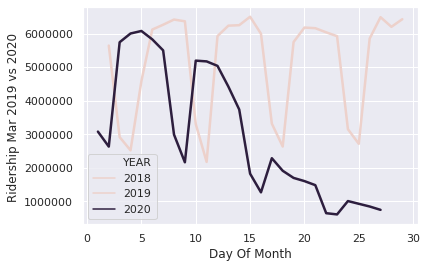

In [84]:
import matplotlib.pyplot as plt
#from matplotlib import datespl
import matplotlib


sns.set()
rplot = sns.lineplot(data=daily_ridership_mar_2020_2019, x='DAY', y = 'DAILY_ENTRIES', linewidth=2.5, hue = 'YEAR')
rplot.set(xlabel='Day Of Month', ylabel='Ridership Mar 2019 vs 2020 ')
plt.show()

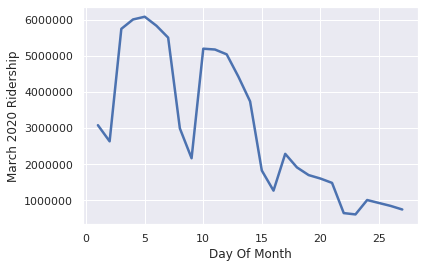

In [77]:

rplot = sns.lineplot(data=daily_ridership_mar_2020, x='DAY', y = 'DAILY_ENTRIES', linewidth=2.5)
rplot.set(xlabel='Day Of Month', ylabel='March 2020 Ridership')
plt.show()

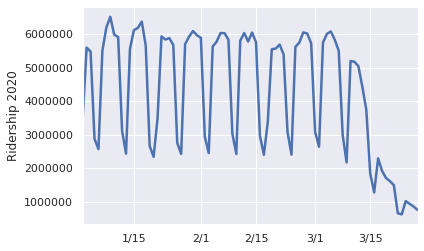

In [101]:
#daily_ridership_2020.reset_index(inplace=True)
daily_ridership_2020 = daily_ridership_2020[~(daily_ridership_2020['DATE'] == pd.Timestamp(2020,1,1))]
rplot = sns.lineplot(data=daily_ridership_2020, x='DATE', y = 'DAILY_ENTRIES', linewidth=2.5)
rplot.set(xlabel='', ylabel='Ridership 2020')
#rplot.set(xticklabels=[])
plt.gca().set_xlim(daily_ridership_2020["DATE"][29],daily_ridership_2020["DATE"][114]) # Put bounds on the current axis
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d')) #gca gets the current axes

plt.show()

In [103]:
 
daily_ridership_2020["DATE"].tail()


110   2020-03-23
111   2020-03-24
112   2020-03-25
113   2020-03-26
114   2020-03-27
Name: DATE, dtype: datetime64[ns]

In [139]:
#https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv
covid_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
#fips, deaths, state to be dropped



In [140]:
covid_cases.drop(["state", 'deaths', 'fips'], axis=1, errors="ignore", inplace=True)
#cover date column to be of type datetime
covid_cases['date'] = pd.to_datetime(covid_cases['date'])




In [143]:
filter_nyc_mask = covid_cases['county'] == 'New York City'
covid_cases_nyc = covid_cases[filter_nyc_mask]
covid_cases_nyc = covid_cases_nyc.reset_index(drop=True)

In [144]:
covid_cases_nyc

,date,county,cases
0,2020-03-01,New York City,1
1,2020-03-02,New York City,1
2,2020-03-03,New York City,2
3,2020-03-04,New York City,2
4,2020-03-05,New York City,4
5,2020-03-06,New York City,5
6,2020-03-07,New York City,12
7,2020-03-08,New York City,14
8,2020-03-09,New York City,20
9,2020-03-10,New York City,37


In [160]:
daily_ridership_mar_2020_merged = daily_ridership_mar_2020.reset_index(drop=True)


In [171]:
covid_cases_nyc = covid_cases_nyc[covid_cases_nyc.date < pd.Timestamp(2020,3,28)]
daily_ridership_mar_2020_merged =daily_ridership_mar_2020_merged.join(covid_cases_nyc['cases'])

In [202]:
daily_ridership_2020

,DATE,DAILY_ENTRIES,YEAR,DAY,MONTH
28,2020-01-01,188961027.0,2020,1,January
29,2020-01-02,3492172.0,2020,2,January
30,2020-01-03,5594854.0,2020,3,January
31,2020-01-04,5476461.0,2020,4,January
32,2020-01-05,2870817.0,2020,5,January
...,...,...,...,...,...
110,2020-03-23,614711.0,2020,23,March
111,2020-03-24,1012345.0,2020,24,March
112,2020-03-25,931021.0,2020,25,March
113,2020-03-26,850405.0,2020,26,March


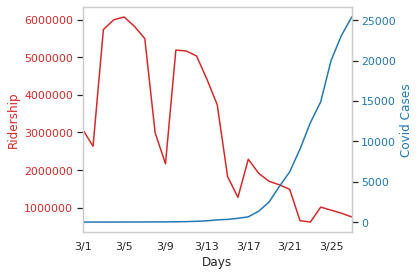

In [184]:
import numpy as np
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})
# Create some mock data
t = daily_ridership_mar_2020_merged['DATE']
data1 = daily_ridership_mar_2020_merged['DAILY_ENTRIES']
data2 = daily_ridership_mar_2020_merged['cases']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Ridership', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Covid Cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gca().set_xlim(daily_ridership_mar_2020_merged["DATE"][0],daily_ridership_mar_2020_merged["DATE"][26] ) # Put bounds on the current axis
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d')) #gca gets the current axes


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [180]:
daily_ridership_mar_2020_merged

,DATE,DAILY_ENTRIES,YEAR,DAY,MONTH,cases
0,2020-03-01,3080249.0,2020,1,March,1
1,2020-03-02,2633847.0,2020,2,March,1
2,2020-03-03,5742299.0,2020,3,March,2
3,2020-03-04,6001685.0,2020,4,March,2
4,2020-03-05,6076706.0,2020,5,March,4
5,2020-03-06,5827679.0,2020,6,March,5
6,2020-03-07,5499328.0,2020,7,March,12
7,2020-03-08,2992368.0,2020,8,March,14
8,2020-03-09,2167217.0,2020,9,March,20
9,2020-03-10,5193889.0,2020,10,March,37


In [170]:
daily_ridership_mar_2020_merged

,DATE,DAILY_ENTRIES,YEAR,DAY,MONTH
0,2020-03-01,3080249.0,2020,1,March
1,2020-03-02,2633847.0,2020,2,March
2,2020-03-03,5742299.0,2020,3,March
3,2020-03-04,6001685.0,2020,4,March
4,2020-03-05,6076706.0,2020,5,March
5,2020-03-06,5827679.0,2020,6,March
6,2020-03-07,5499328.0,2020,7,March
7,2020-03-08,2992368.0,2020,8,March
8,2020-03-09,2167217.0,2020,9,March
9,2020-03-10,5193889.0,2020,10,March
